# Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

# Importing Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from google.colab.patches import cv2_imshow

# Loading Data
The dataset contains 2000 images and matlab file contains 3 labels of angels

In [3]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

#  Preparing Data 
### Steps :


*   extracting names and faces points from matl file  .
*   loading image and its correspinding mat file.

*  processing the face to extract the landmark points (468 point) for each x,y,z.
*   The x and y values are scaled to the their width and height so we will get. back their actual value in the image.

*   loading the mat file to extract the labels (pitch,yaw,roll) and extracting the labels 3 angels.
*    converting the lists to numpy arrays.









In [4]:
# extracting names and faces points from matl file  
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])
faceModule = mediapipe.solutions.face_mesh

detected_files = []
X_overall = []
Y_overall = []
labels = []


# loading image and its correspinding mat file
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the faces in the image
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              X.append(relative_x)
              Y.append(relative_y)
          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image overall
          X_overall.append(X)
          Y_overall.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

X_overall = np.array(X_overall)
Y_overall = np.array(Y_overall)
labels = np.array(labels)

pitch_label = labels[:,0]  # the first label (pitch)
yaw_label = labels[:,1]    # the first label (yaw)
roll_label = labels[:,2]   # the first label (roll)
print('X_overall shape:' ,X_overall.shape)
print('Y_overall shape:' ,Y_overall.shape)
print('labels shape   :' ,labels.shape)

X_overall shape: (1853, 468)
Y_overall shape: (1853, 468)
labels shape   : (1853, 3)


#  Preprocessing Data
###steps :


1.   Centering the data (we assume that the center arround 97th point that represents the Nose point as standard of centering .
2.   Normalizing the data (assume the normalization range between the two sides of face width 10 and 170).
3.  Computing the eculedian distance and divide the center to this distance.








In [40]:
#we should center the data because of the differances of faces dimensions 
# centering the data arround the 97th point 
Center_X = X_overall - X_overall[:,97].reshape(-1,1) 
Center_Y = Y_overall - Y_overall[:,97].reshape(-1,1)

# normalizing the data 
#assume the normalization range between 10 and 170
X_170 = X_overall[:,170]
X_10 = X_overall[:,10]
Y_170 = Y_overall[:,170]
Y_10 = Y_overall[:,10]
# computing the distance
Ecl_distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_170,Y_170)),axis = 0).reshape(-1,1)
Norm_X = Center_X / Ecl_distance
Norm_Y = Center_Y /Ecl_distance 

features = np.hstack([Norm_X,Norm_Y])
print('features shape:',features.shape)

features shape: (1853, 936)


# Splitting Data


*   test size = 0.2
*   extract 3 angels from labels




In [41]:
# splitting the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test,file_train,file_test = train_test_split(features,labels,detected_files,test_size = 0.25,random_state = 40)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_test_pitch = y_test[:,0]
y_test_yaw = y_test[:,1]
y_test_roll = y_test[:,2]

# **Applying different models for training data**

# 1) Linear Regression 


*   Apply Linear regression for 3 models ( Pitch - Yaw - Roll ) . 
*   Checking mean absolute error for each model .



In [47]:
#linear Regression 
#pitch model
reg_p = LinearRegression()
reg_p.fit(X_train, y_train_pitch)
print('Pitch results')
print('score of train pitch :' , reg_p.score(X_train, y_train_pitch))
print( '---------------------------------')
print('Error of train pitch :' ,mean_absolute_error(reg_p.predict(X_train), y_train_pitch))
print('Error of test pitch  :' ,mean_absolute_error(reg_p.predict(X_test), y_test_pitch))
print('============================================================================================')

#yaw_model
reg_y = LinearRegression()
reg_y.fit(X_train, y_train_yaw)
print('Yaw results')
print('score of train pitch :' , reg_y.score(X_train, y_train_yaw))
print( '---------------------------------')
print('Error of train yaw   :' ,mean_absolute_error(reg_y.predict(X_train), y_train_yaw))
print('Error of test pitch  :' ,mean_absolute_error(reg_y.predict(X_test), y_test_yaw))
print('============================================================================================')


#roll_model
reg_r = LinearRegression()
reg_r.fit(X_train, y_train_roll)
print('Roll results')
print('score of train pitch :' , reg_r.score(X_train, y_train_roll))
print( '---------------------------------')
print('Error of train roll  :' ,mean_absolute_error(reg_r.predict(X_train), y_train_roll))
print('Error of test pitch  :' ,mean_absolute_error(reg_r.predict(X_test), y_test_roll))


Pitch results
score of train pitch : 0.7418295638925775
---------------------------------
Error of train pitch : 0.21528125732928852
Error of test pitch  : 0.5938227176969405
Yaw results
score of train pitch : 0.9580222683028822
---------------------------------
Error of train yaw   : 0.08620668077983237
Error of test pitch  : 0.2585745269398458
Roll results
score of train pitch : 0.8656372027222861
---------------------------------
Error of train roll  : 0.19866830564207108
Error of test pitch  : 0.6178342507618504


# 2) SVR
##a - using kernel=" poly " and checking train accuracy .

*   c = 100
*   degree = 10



In [49]:
#SVR (using kernel='poly' )
#pitch model
svr_p = SVR(kernel='poly', C=100, gamma='auto', degree=10, epsilon=.1,coef0=1)
svr_p.fit(X_train, y_train_pitch)
print('Error of train pitch (SVR):' ,mean_absolute_error(svr_p.predict(X_train), y_train_pitch))
print('Error of test pitch(SVR)  :' ,mean_absolute_error(svr_p.predict(X_test), y_test_pitch))
print('============================================================================================')

#yaw_model
svr_y = SVR(kernel='poly', C=100, gamma='auto', degree=10, epsilon=.1,coef0=1)
svr_y.fit(X_train, y_train_yaw)
print('Error of train yaw (SVR):' ,mean_absolute_error(svr_y.predict(X_train), y_train_yaw))
print('Error of test yaw(SVR)  :' ,mean_absolute_error(svr_y.predict(X_test), y_test_yaw))
print('============================================================================================')


#roll_model
svr_r = SVR(kernel='poly', C=100, gamma='auto', degree=10, epsilon=.1,coef0=1)
svr_r.fit(X_train, y_train_roll)
print('Error of train roll (SVR):' ,mean_absolute_error(svr_r.predict(X_train), y_train_roll))
print('Error of test roll(SVR)  :' ,mean_absolute_error(svr_p.predict(X_test), y_test_roll))




Error of train pitch (SVR): 0.10041931722405
Error of test pitch(SVR)  : 0.08139986339647795
Error of train yaw (SVR): 0.06981392036216058
Error of test yaw(SVR)  : 0.0647854569716218
Error of train roll (SVR): 0.08038526835175756
Error of test roll(SVR)  : 0.28627276263950463


##b - Using Kernel = " rbf " and checking train accuracy.

*   c = 100
*   degree = 10



In [51]:
#SVR (using kernel='rbf' )
#pitch model
svr_p = SVR(kernel='rbf', C=100, gamma='auto', degree=10, epsilon=.1,coef0=1)
svr_p.fit(X_train, y_train_pitch)
print('Error of train pitch (SVR):' ,mean_absolute_error(svr_p.predict(X_train), y_train_pitch))
print('Error of test pitch(SVR)  :' ,mean_absolute_error(svr_p.predict(X_test), y_test_pitch))
print('============================================================================================')

#yaw_model
svr_y = SVR(kernel='rbf', C=100, gamma='auto', degree=10, epsilon=.1,coef0=1)
svr_y.fit(X_train, y_train_yaw)
print('Error of train yaw (SVR):' ,mean_absolute_error(svr_y.predict(X_train), y_train_yaw))
print('Error of test yaw(SVR)  :' ,mean_absolute_error(svr_y.predict(X_test), y_test_yaw))
print('============================================================================================')


#roll_model
svr_r = SVR(kernel='rbf', C=100, gamma='auto', degree=10, epsilon=.1,coef0=1)
svr_r.fit(X_train, y_train_roll)
print('Error of train roll (SVR):' ,mean_absolute_error(svr_r.predict(X_train), y_train_roll))
print('Error of test roll(SVR)  :' ,mean_absolute_error(svr_p.predict(X_test), y_test_roll))

Error of train pitch (SVR): 0.10756380241002536
Error of test pitch(SVR)  : 0.08315117018818692
Error of train yaw (SVR): 0.07543627034963232
Error of test yaw(SVR)  : 0.06437423107321094
Error of train roll (SVR): 0.08747997804824083
Error of test roll(SVR)  : 0.2804768597259068


##c - Using Kernel = " sigmoid " and checking train accuracy.

*   c = 100
*   degree = 10

In [53]:
 #SVR (using kernel='sigmoig' )
 #pitch model
svr_p = SVR(kernel='sigmoid', C=100, gamma='auto', degree=10, epsilon=.1,coef0=1)
svr_p.fit(X_train, y_train_pitch)
print('Error of train pitch (SVR):' ,mean_absolute_error(svr_p.predict(X_train), y_train_pitch))
print('Error of test pitch(SVR)  :' ,mean_absolute_error(svr_p.predict(X_test), y_test_pitch))
print('============================================================================================')

#yaw_model
svr_y = SVR(kernel='sigmoid', C=100, gamma='auto', degree=10, epsilon=.1,coef0=1)
svr_y.fit(X_train, y_train_yaw)
print('Error of train yaw (SVR):' ,mean_absolute_error(svr_y.predict(X_train), y_train_yaw))
print('Error of test yaw(SVR)  :' ,mean_absolute_error(svr_y.predict(X_test), y_test_yaw))
print('============================================================================================')

#roll_model
svr_r = SVR(kernel='sigmoid', C=100, gamma='auto', degree=10, epsilon=.1,coef0=1)
svr_r.fit(X_train, y_train_roll)
print('Error of train roll (SVR):' ,mean_absolute_error(svr_r.predict(X_train), y_train_roll))
print('Error of test roll(SVR)  :' ,mean_absolute_error(svr_p.predict(X_test), y_test_roll))

Error of train pitch (SVR): 0.38839743870215526
Error of test pitch(SVR)  : 0.3473160918929371
Error of train yaw (SVR): 0.32919275151028243
Error of test yaw(SVR)  : 0.30381377654143144
Error of train roll (SVR): 0.37381857918679123
Error of test roll(SVR)  : 0.4341811822896872


#**NOTES :**
##Acorrding to different Models ( Linear Regression - SVR  ) we notice that **SVR** is better than Linear Regression because the mean absolute error is smaller.
##Now we have a problem ; we should know the best model of SVR ,we should determine :

*   the best kernel :" poly - rbf - sigmoid "
*   the best C value: " 0.1 , 1 , 10 , 100 "

*   thr best degree if best kernel is " poly "
# To achieve that we must use **GridSearch for SVR** in our case .








#  GridSearch for SVR models

*   We apply SVR GridSearch for  models ( Pitch - Yaw - Roll ) .
*   We select the Best model with best parameters that achieve the optimum mean absolute error .




In [54]:
# Grid Search
#grid search pitch
svr = SVR()
svr_gs_p = GridSearchCV(estimator = svr,param_grid = {'kernel':[ 'poly', 'rbf', 'sigmoid'],'C':[0.1 , 1 , 10 , 100]})
svr_gs_p.fit(X_train, y_train_pitch)
svr_best_pitch = svr_gs_p.best_estimator_
print('pitch model results ')
print("Pitch Best Model  : ",svr_best_pitch)
print( '---------------------------------')
print('Train patch score    :',svr_best_pitch.score(X_train, y_train_pitch))
print("Error of Train pitch : ",mean_absolute_error(svr_best_pitch.predict(X_train),y_train_pitch))
print("Error of Test pitch  : ",mean_absolute_error(svr_best_pitch.predict(X_test),y_test_pitch))

print('================================================================================================================================')

#grid search yaw
svr = SVR()
svr_gs_y = GridSearchCV(estimator = svr,param_grid = {'kernel':[ 'poly', 'rbf', 'sigmoid'],'C':[0.1 , 1 , 10 , 100]})
svr_gs_y.fit(X_train, y_train_yaw)
svr_best_yaw = svr_gs_y.best_estimator_
print('yaw model results ')
print("Yaw Best Model     : ",svr_best_yaw)
print('Train yaw score    :',svr_best_yaw.score(X_train, y_train_yaw))
print( '---------------------------------')
print('Error of Train yaw :   :',mean_absolute_error(svr_best_yaw.predict(X_train),y_train_yaw))
print("Error of Test yaw  : ",mean_absolute_error(svr_best_yaw.predict(X_test),y_test_yaw))

print('===================================================================================================================================')

# grid search roll
svr = SVR()
svr_gs_r = GridSearchCV(estimator = svr,param_grid = {'kernel':[ 'poly', 'rbf', 'sigmoid'],'C':[0.1 , 1 , 10 , 100]})
svr_gs_r.fit(X_train, y_train_roll)
svr_best_roll = svr_gs_r.best_estimator_
print('roll model results ')
print("Yaw Best Model      : ",svr_best_roll)
print('Train roll score    :',svr_best_roll.score(X_train, y_train_roll))
print( '---------------------------------')
print("Error of Train roll : ",mean_absolute_error(svr_best_roll.predict(X_train),y_train_roll))
print("Error of Test roll  : ",mean_absolute_error(svr_best_roll.predict(X_test),y_test_roll))



pitch model results 
Pitch Best Model  :  SVR(C=10, kernel='poly')
---------------------------------
Train patch score    : 0.17028588846022663
Error of Train pitch :  0.10287543442868917
Error of Test pitch  :  0.08072261253053298
yaw model results 
Yaw Best Model     :  SVR(C=10, kernel='poly')
Train yaw score    : 0.8622338056387111
---------------------------------
Error of Train yaw :   : 0.07266633651550909
Error of Test yaw  :  0.06524994372165044
roll model results 
Yaw Best Model      :  SVR(C=100)
Train roll score    : 0.3781535401158891
---------------------------------
Error of Train roll :  0.07753226697069222
Error of Test roll  :  0.07017434372229628



##Acorrding to  **GridSearch for SVR** we select the best model with best parameters for each angle . 
# Now we can apply the best model for our problem case ⚡

#Drawing the 3 axis 

*   X-Axis pointing to right that's drawn by red .
*   Y-Axis pointing to right drawn by green .

*   Z-Axis (out of the screen) drawn by blue .






In [12]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2
    # X-Axis pointing to right. drawn by red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
    # Y-Axis | drawn by green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn by blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

# Visualing Random image and drawing its points and axis .

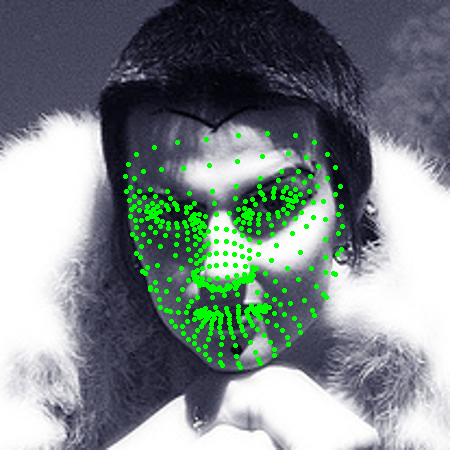

In [13]:
# choosing random image from the testing data
image_name = random.choice(file_test)
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # 
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    cv2_imshow(frame)

# Drawing the axis from the train label on any image 

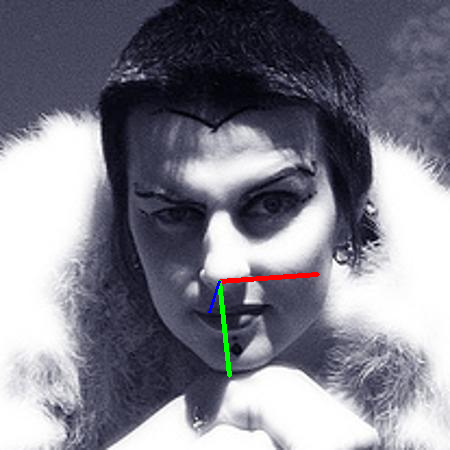

In [14]:
# reading the image
frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
# reading the true labels and drawing the axis on the image
mat = sio.loadmat('/content/AFLW2000/' + image_name + '.mat')
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true,X[99],Y[99]))

# Testing GridSearch model 

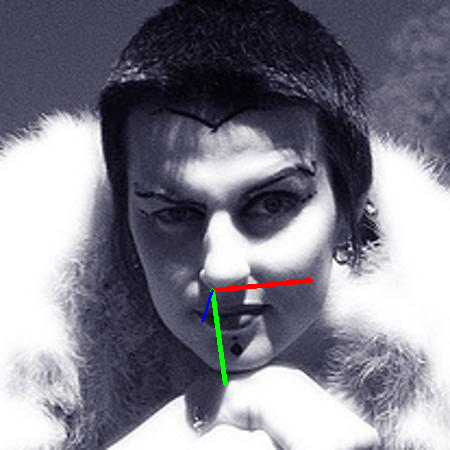

In [15]:
# choosing random image from the testing data######
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X and Y lists
            X.append(relative_x)
            Y.append(relative_y)

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 99
        X_center = X - X[99]
        Y_center = Y - Y[99]
        # computing the distance between the point 171 and 10
        d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
        # normalizing the points
        X_norm = X_center/d
        Y_norm = Y_center/d
        X_norm = X_norm
        Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = svr_best_pitch.predict(points)
        pred_yaw = svr_best_yaw.predict(points)
        pred_roll = svr_best_roll.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[97],Y[97]))

# Loading the test video

In [55]:
%%capture
!git clone https://github.com/MahmoudElsherief95/Machine-Learning-project-Head-Pose-Estimation-

# Testing GridSearch model on the video

In [56]:
cap = cv2.VideoCapture('/content/Testing Video _3.mp4')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video file")

# initializing a list to store the frames   
img_array = []
# Read until video is completed
while(cap.isOpened()):   
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
      with faceModule.FaceMesh(static_image_mode=True) as face:
        # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
        results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              # initializing X and Y lists to store the spacial coordinates of the points
              X = []
              Y = []
              # looping over the landmarks to extract x and y
              for j,landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  # retrieve the true values of x and y
                  shape = frame.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  X.append(relative_x)
                  Y.append(relative_y)

              X = np.array(X)
              Y = np.array(Y)
              # centering the data arround the point 99
              X_center = X - X[99]
              Y_center = Y - Y[99]
              d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
              X_norm = X_center/d
              Y_norm = Y_center/d
              points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
              # predicting the 3 angels to draw the axis on the image
              pred_pitch = svr_best_pitch.predict(points)
              pred_yaw = svr_best_yaw.predict(points)
              pred_roll = svr_best_roll.predict(points)
              
            
              draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99])
              # appending the result frame to the img_array list
              img_array.append(frame)
    # Break the loop
    else: 
        break
cap.release()  
# Closes all the frames
cv2.destroyAllWindows()
print("Number of Detected Frames = ",len(img_array))
# converting the frames to video
out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(img_array)):
  out.write(img_array[i])
out.release()

Number of Detected Frames =  742


In [34]:
from google.colab import files
files.download('/content/out.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>